<h1> BERT: Initial Training </h1>

Here I:

1. Set hyperparameters: maximum sample length, epochs, learning rate, etc...
2. Pretrain BERT-base cased on the whole dataset.
3. Fine-tune the model on a classification task.
4. Report initial results and next steps.

Note that some of the larger functions and classes were packaged in common.py to make the content here more readable.

In [34]:
import os
import re
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import importlib
import pickle

import common
from common import ClassificationDataset, nsp_mlm_pretrain, train_test_val_split, make_nsp_dataset

import torch
from torchmetrics import F1Score
from transformers import BertTokenizer
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

torch.has_mps # for Mac ARM build, needed for GPU

True

In [35]:
# Directories

project_dir = "/Users/paulp/Library/CloudStorage/OneDrive-UniversityofEasternFinland/UEF/Thesis"
data_dir = os.path.join(project_dir, "Data")
model_dir = os.path.join(project_dir, 'Models')
os.chdir(data_dir)

# Tokenizer

with open('spec_tokens_ne.txt', 'rb') as file:
    spec_tokens = pickle.load(file)

tokenizer = BertTokenizer.from_pretrained('bert-base-cased', 
                                          additional_special_tokens = spec_tokens)

# Main Data

dataset = pd.read_csv('ne_masked_dataset.csv', index_col = 0)
dataset['Target'] = pd.Categorical(dataset['Target'])

with open("target_idx.json") as file:
    target_idx = json.load(file)
    
n_classes = len(target_idx.keys())

dataset.head()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


,Unnamed: 0,Corpus,Target,Text,Length
0,0,ICLE,GE,I 've been making music now for 20 years . You...,390
1,1,ICLE,GE,A quick inspection of the waste - paper basket...,557
2,2,ICLE,CN,Recycling of waste has long been a controversi...,587
3,3,ICLE,CN,"Few years age , government in some cities such...",785
4,4,ICLE,JP,"Gender discrimination . These Days , we often ...",829


<h1> Train, Validation, and Test Split </h1>

~ 8 hrs.

1. Split the data randomly
2. Check that target classes are represented in each set with similar proportions

For a dataset this large, data imbalance should not be an issue, but it is still beneficial to check how the L1s are distributed through the sets.

*help from : https://discuss.pytorch.org/t/train-test-split-using-subsetrandomsampler/105447
see 'commmon.py' for custom functions and classes used.*

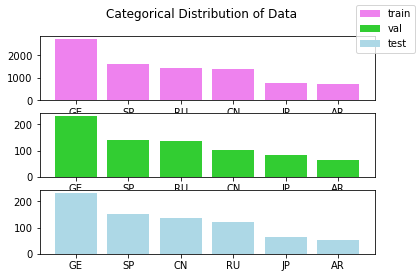

In [11]:
ds_train, ds_val, ds_test = train_test_val_split(dataset, 
                                                 train_split = 0.85, 
                                                 val_split = 0.07, 
                                                 test_split = 0.08)

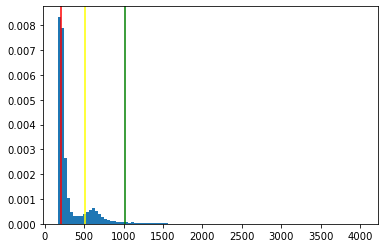

In [12]:
distribution = plt.hist(dataset['Length'], bins=100, density=True, label='Distribution of Text Lengths')
plt.axvline(x=206, color="red")
plt.axvline(x=512, color="yellow")
plt.axvline(x=1024, color='green')

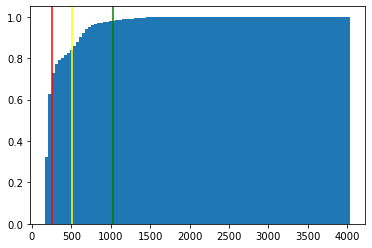

In [13]:
cumulative = plt.hist(dataset['Length'], bins=100, density=True, cumulative=True, label='Distribution of Text Lengths')
plt.axvline(x=1024, color='green')
plt.axvline(x=512, color='yellow')
plt.axvline(x=256, color='red')


The yellow line at 512 indicates the standard 'max_seq_len' for BERT models, meaning the model only takes text sequences this long, and the ends are clipped. If sequences are shorter, padding tokens are added to the end of the sequence. 

This means there will be a tradeoff between data loss (clipping) and sparsity (padding), depending on the max length chosen. Longer max lengths also require longer training times.

I attempted maximum sequence lengths of 1536 (not pictured) and 1024 (green). 1536 is too large for my available RAM, and, while 1024 trained well, it took about 4 hours per epoch: because multiple rounds of training will be necessary (for example, with k-fold cross-validation), I have stepped this down to 256 (red) for now. This shorter length may also be a wise choice for baseline comparison with GNN, which is quite expensive computationally. Note below the loss of data this incurs. 


In [57]:
a = dataset.query("Length <=512").size/dataset.size
b = dataset.query("Length <=1024").size/dataset.size
c = dataset.query("Length <=256").size/dataset.size
print(f'Percent whole texts captured at 512 : {a} \n', 
      f'Percent whole texts captured at 1012 : {b} \n',
     f'Percent whole texts captured at 256 : {c} \n')

Percent whole texts captured at 512 : 0.8373630711536564 
 Percent whole texts captured at 1012 : 0.9793743215237344 
 Percent whole texts captured at 256 : 0.6641665844271193 



In [15]:
# save datasets
ds_train.to_csv(os.path.join(data_dir, 'train.csv'))
ds_val.to_csv(os.path.join(data_dir, 'val.csv'))
ds_test.to_csv(os.path.join(data_dir, 'test.csv'))

<h1>Pretraining</h1>

~ 16 hrs.

Although we are clipping samples at 256, this does not mean we cannot use the clipped ends to pretrain the model. I certainly cannot use them in the classification fine-tuning, as this would pollute the data.

Pretraining BERT requires next-sentence prediction (NSP), in which the data is split into sentence pairs. The model is then tasked with predicting whether the second sentence logically follows the first. To generate negative samples, the second sentence is randomly sampled from the corpus. 

The model is also tasked with Masked Language Modeling (MLM) in pretraining. In this task, 15% of tokens in the data are replaced with masks, and the model must reconstruct the original sequence, much like a cloze or fill-in-the-blank test. 

*Functions from common.py are only slightly modified from:
https://towardsdatascience.com/how-to-train-bert-aaad00533168*


In [20]:
import random 
from nltk.tokenize import sent_tokenize

from common import make_nsp_dataset, PretrainDataset

from tqdm import tqdm  # progress bar for training
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup, BertForPreTraining

# device
use_mps = torch.has_mps
device = torch.device('mps' if use_mps else 'cpu')

In [24]:
max_seq_len = 256
lr = 5e-5
n_epochs = 2

<h2> NSP & MLM Dataset </h2>

In [25]:
nsp_inputs = make_nsp_dataset(dataset['Text'], 
                              tokenizer=tokenizer, 
                              max_len = max_seq_len)

nsp_inputs.keys()

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'next_sentence_label', 'labels'])

<h2> Pretraining Settings and Loop </h2>

In [26]:
pretrain_dataset = PretrainDataset(nsp_inputs)
pretrain_loader = torch.utils.data.DataLoader(pretrain_dataset, batch_size=16, shuffle=True)

configuration = BertConfig(max_position_embeddings = max_seq_len)
pretraining_model = BertForPreTraining( 
                            config=configuration
                          )

pretraining_model.to(device)
pretraining_model.train()

optim = torch.optim.AdamW(pretraining_model.parameters(), lr = lr)


In [27]:
# train
pretrain_loss = nsp_mlm_pretrain(pretraining_model, 
                                 pretrain_loader, 
                                 device, 
                                 optim, 
                                 n_epochs=n_epochs)

Epoch 1: 100%|██████████████████| 632/632 [2:23:26<00:00, 13.62s/it, loss=0.986]


In [28]:
# save model
model_prefix = f'PRE_{max_seq_len}_{n_epochs}E_{lr}_NEmask'

state_dict_path = os.path.join(model_dir, model_prefix+'_state_dict.pt')
model_path = os.path.join(model_dir, model_prefix+'_model.pt')

#pretraining_model.save_pretrained(state_dict_path)
pretrain_model_dir = os.path.join(model_dir, model_prefix)
pretraining_model.save_pretrained(pretrain_model_dir)

<h1>Fine-Tuning</h1>

~20 hrs.

The pretrained model from above into the classification architecture. Here the model is tasked with the classifying texts to their L1 target. 

*help from: https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f
https://mccormickml.com/2019/07/22/BERT-fine-tuning/
https://gmihaila.github.io/tutorial_notebooks/bert_inner_workings/*


In [63]:
# training parameters
batch_size = 2
n_epochs = 2
lr = 3e-3


classification_model = BertForSequenceClassification.from_pretrained(
    pretrain_model_dir,
    num_labels = n_classes,
    output_attentions = False,
    output_hidden_states = False) 


Some weights of the model checkpoint at /Users/paulp/Library/CloudStorage/OneDrive-UniversityofEasternFinland/UEF/Thesis/Models/PRE_256_2E_5e-05_NEmask were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertFor

In [36]:
#create the dataset objects
ds_tr = ClassificationDataset(ds_train, tokenizer, target_idx, max_seq_len)
ds_vl = ClassificationDataset(ds_val, tokenizer, target_idx, max_seq_len)
ds_ts = ClassificationDataset(ds_test, tokenizer, target_idx, max_seq_len)

In [37]:
train_dataloader = DataLoader(
    ds_tr, 
    sampler = RandomSampler(ds_tr), 
    batch_size=batch_size
)

validation_dataloader = DataLoader(
    ds_vl,
    sampler = SequentialSampler(ds_vl),
    batch_size = batch_size)

In [38]:
epochs = 2
LR = 1e-5
n_warmup = 0

total_steps = len(train_dataloader)*epochs
optimizer = torch.optim.AdamW(classification_model.parameters(), lr = LR, eps = 1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = n_warmup,
                                           num_training_steps = total_steps)

metric = F1Score(num_classes = n_classes)

In [44]:
# Train and store the training stats in a variable

train_stats = BERT_fine_tune_train(classification_model,
                                  train_dataloader,
                                  validation_dataloader,
                                  device,
                                   metric,
                                   optimizer,
                                   scheduler,
                                   epochs = n_epochs
                                  )


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  4,358.    Elapsed: 0:00:43.
  Batch    80  of  4,358.    Elapsed: 0:01:14.
  Batch   120  of  4,358.    Elapsed: 0:01:44.
  Batch   160  of  4,358.    Elapsed: 0:02:14.
  Batch   200  of  4,358.    Elapsed: 0:02:43.
  Batch   240  of  4,358.    Elapsed: 0:03:13.
  Batch   280  of  4,358.    Elapsed: 0:03:42.
  Batch   320  of  4,358.    Elapsed: 0:04:12.
  Batch   360  of  4,358.    Elapsed: 0:04:44.
  Batch   400  of  4,358.    Elapsed: 0:05:16.
  Batch   440  of  4,358.    Elapsed: 0:05:49.
  Batch   480  of  4,358.    Elapsed: 0:06:22.
  Batch   520  of  4,358.    Elapsed: 0:06:54.
  Batch   560  of  4,358.    Elapsed: 0:07:27.
  Batch   600  of  4,358.    Elapsed: 0:07:59.
  Batch   640  of  4,358.    Elapsed: 0:08:32.
  Batch   680  of  4,358.    Elapsed: 0:09:04.
  Batch   720  of  4,358.    Elapsed: 0:09:37.
  Batch   760  of  4,358.    Elapsed: 0:10:09.
  Batch   800  of  4,358.    Elapsed: 0:10:42.
  Batch   840  of

  Batch 2,480  of  4,358.    Elapsed: 1:23:38.
  Batch 2,520  of  4,358.    Elapsed: 1:25:13.
  Batch 2,560  of  4,358.    Elapsed: 1:26:41.
  Batch 2,600  of  4,358.    Elapsed: 1:28:20.
  Batch 2,640  of  4,358.    Elapsed: 1:29:57.
  Batch 2,680  of  4,358.    Elapsed: 1:31:43.
  Batch 2,720  of  4,358.    Elapsed: 1:33:19.
  Batch 2,760  of  4,358.    Elapsed: 1:34:50.
  Batch 2,800  of  4,358.    Elapsed: 1:36:36.
  Batch 2,840  of  4,358.    Elapsed: 1:38:10.
  Batch 2,880  of  4,358.    Elapsed: 1:39:42.
  Batch 2,920  of  4,358.    Elapsed: 1:41:18.
  Batch 2,960  of  4,358.    Elapsed: 1:43:02.
  Batch 3,000  of  4,358.    Elapsed: 1:44:31.
  Batch 3,040  of  4,358.    Elapsed: 1:46:01.
  Batch 3,080  of  4,358.    Elapsed: 1:47:39.
  Batch 3,120  of  4,358.    Elapsed: 1:49:04.
  Batch 3,160  of  4,358.    Elapsed: 1:50:31.
  Batch 3,200  of  4,358.    Elapsed: 1:51:52.
  Batch 3,240  of  4,358.    Elapsed: 1:53:16.
  Batch 3,280  of  4,358.    Elapsed: 1:54:58.
  Batch 3,320

<h1> Test </h1>

~ 8 hrs.

Here I report the confusion matrix and f1 score.

help from : https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

In [46]:
test_dataloader = DataLoader(
    ds_ts,
    sampler = SequentialSampler(ds_vl),
    batch_size = batch_size)

test_stats = BERT_fine_tune_validation(classification_model, 
                                validation_dataloader, device,
                                metric = F1Score(num_classes = n_classes))


Running Validation...
  Accuracy: 0.39
  Validation Loss: 1.52
  Validation F1 Score: 0.392
  Validation took: 0:00:44


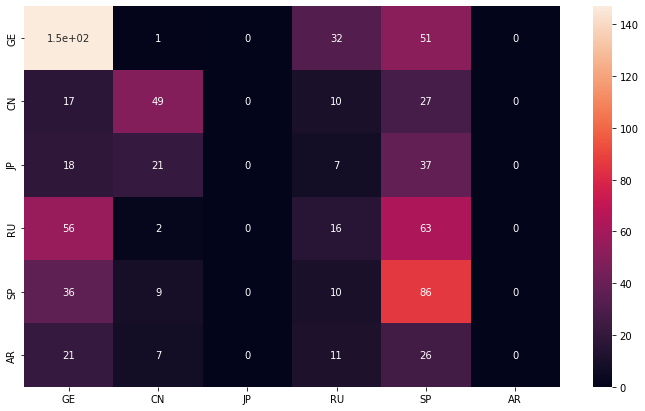

In [52]:
idx_target = {target_idx[a]:a for a in target_idx.keys()}
plot_confusion_matrix(test_stats['y_true'], test_stats['y_pred'], idx_target)

In [53]:
cls_model_dir = os.path.join(model_dir,'classifier')
cls_state_dict_path = os.path.join(cls_model_dir, f'CLS_{epochs}ep_{max_seq_len}_{LR}LR_NEmasked.pt')
cls_model_path = os.path.join(cls_model_dir, f'CLS_{epochs}ep_{max_seq_len}_{LR}_NEmasked_state_dict.pt')

torch.save(classification_model.state_dict(), cls_state_dict_path)
torch.save(classification_model, cls_model_path)
classification_model.save_pretrained(cls_model_dir)

<h2> Findings and Next Steps </h2>

Evidenced by false negative rates, it appears that the model is defaulting to German and Spanish, the dominant targets in the corpus. This calls for **regularization** in the next iteration of model training. Also, Dynamic Masking, as used in **RoBERTa**, may assist in pretraining gains. I will try one more round of BERT-base with L2 regularization and lower dropout (0.05) before moving on to RoBERTa and GNN. Although not shown here, four additional epochs of training did not lead to any notable gains.

<h1> Resources </h1>

Bernecker, C. (2021, January 27). How to create a confusion matrix in Pytorch | Medium. Medium; Medium. https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

Briggs, J. (2021, June 15). How to Fine-Tune BERT Transformer Python | Towards Data Science. Medium; Towards Data Science. https://towardsdatascience.com/how-to-train-bert-aaad00533168

McCormick, Chris . (2019, July 22). BERT Fine-Tuning Tutorial with PyTorch · Mccormickml.com. https://mccormickml.com/2019/07/22/BERT-fine-tuning/

Mihaila, George . (2015). Bert Inner Workings. Github.io. https://gmihaila.github.io/tutorial_notebooks/bert_inner_workings/

PyTorch Forums. (2020, December 7). Train Test Split using SubsetRandomSampler. https://discuss.pytorch.org/t/train-test-split-using-subsetrandomsampler/105447

Winastwan, R. (2021, November 10). Text Classification with BERT in PyTorch - Towards Data Science. Medium; Towards Data Science. https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

